# Import packages and datasets

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sales_train_val = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sales_train_validation.csv')

# Filter dataset because we only two-year training (too distant past observation and test data)

In [ ]:
list_cols_drop = ['d_{0}'.format(i) for i in range(1, 1168)] + ['d_{0}'.format(i) for i in range(1900, 1914)]

In [ ]:
sales_train_val = sales_train_val.drop(columns=list_cols_drop)

In [ ]:
sales_train_val

# Get sales data of Foods in California stores

In [ ]:
df_ca_foods = sales_train_val[(sales_train_val['state_id'] == 'CA') & (sales_train_val['cat_id'] == 'FOODS')]

In [ ]:
df_ca_category = df_ca_foods.copy()

df_ca_category.drop(['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], axis = 1, inplace=True)
df_ca_category = pd.melt(df_ca_category, id_vars=['id'])
df_ca_category['Date'] = df_ca_category['variable'].str[2:].astype('int')

dict_date = {}
for i in range(1, 1914):
    dict_date.update({i: (pd.to_datetime('28/01/2011', format='%d/%m/%Y') + pd.to_timedelta(i, unit='D'))})
    
df_ca_category['Date'] = df_ca_category['Date'].map(dict_date)

df_ca_category = df_ca_category[['Date', 'id', 'value']]

In [ ]:
df_ca_category

,Date,id,value
0,2014-04-10,FOODS_1_001_CA_1_validation,0
1,2014-04-10,FOODS_1_002_CA_1_validation,0
2,2014-04-10,FOODS_1_003_CA_1_validation,0
3,2014-04-10,FOODS_1_004_CA_1_validation,16
4,2014-04-10,FOODS_1_005_CA_1_validation,0
...,...,...,...
4207531,2016-04-10,FOODS_3_823_CA_4_validation,0
4207532,2016-04-10,FOODS_3_824_CA_4_validation,0
4207533,2016-04-10,FOODS_3_825_CA_4_validation,0
4207534,2016-04-10,FOODS_3_826_CA_4_validation,2


# Coefficient of Variance Squared (CV2)

In [ ]:
df_ca_category_1 = df_ca_category[df_ca_category['value'] != 0]

In [ ]:
cv_data = df_ca_category_1.groupby('id').agg(average=('value','mean'),
                                 sd=('value','std')).reset_index()

cv_data['cv_sqr'] = (cv_data['sd'] / cv_data['average'])**2

In [ ]:
cv_data

,id,average,sd,cv_sqr
0,FOODS_1_001_CA_1_validation,1.658307,1.036679,0.390803
1,FOODS_1_001_CA_2_validation,2.069486,1.754131,0.718454
2,FOODS_1_001_CA_3_validation,2.784615,3.547765,1.623227
3,FOODS_1_001_CA_4_validation,1.474359,0.904817,0.376630
4,FOODS_1_002_CA_1_validation,1.319502,0.620478,0.221122
...,...,...,...,...
5743,FOODS_3_826_CA_4_validation,2.216758,1.325773,0.357686
5744,FOODS_3_827_CA_1_validation,4.338323,3.294718,0.576757
5745,FOODS_3_827_CA_2_validation,3.577947,3.539392,0.978565
5746,FOODS_3_827_CA_3_validation,5.449339,6.151210,1.274188


# Average Demand Interval (ADI) per Product

In [ ]:
prod_by_date = df_ca_category_1.groupby(['id','Date']).agg(count=('id','count')).reset_index()
skus = prod_by_date.id.value_counts()

In [ ]:
from timeit import default_timer as timer
start = timer()

list_adi = list()
for i in range(len(skus.index)):
    a = prod_by_date[prod_by_date['id']==skus.index[i]]
    a['Previous_Date'] = a['Date'].shift(1)
    a['Duration'] = (a['Date'] - a['Previous_Date']).dt.days
    mean_temp = a.Duration.mean()
    list_adi.append([skus.index[i], mean_temp])

end = timer()
print('This line of code took {} minutes'.format((end-start) / 60))

This line of code took 14.006437551500001 minutes


In [ ]:
list_adi[:5]

[['FOODS_3_586_CA_2_validation', 1.0013698630136987],
 ['FOODS_3_555_CA_3_validation', 1.0013698630136987],
 ['FOODS_3_080_CA_2_validation', 1.0013698630136987],
 ['FOODS_3_714_CA_1_validation', 1.0027434842249656],
 ['FOODS_3_586_CA_3_validation', 1.0027434842249656]]

In [ ]:
ADI_df = pd.DataFrame(list_adi, columns=['id', 'ADI'])

In [ ]:
ADI_df

,id,ADI
0,FOODS_3_586_CA_2_validation,1.001370
1,FOODS_3_555_CA_3_validation,1.001370
2,FOODS_3_080_CA_2_validation,1.001370
3,FOODS_3_714_CA_1_validation,1.002743
4,FOODS_3_586_CA_3_validation,1.002743
...,...,...
5743,FOODS_1_212_CA_4_validation,4.625000
5744,FOODS_1_168_CA_4_validation,3.285714
5745,FOODS_1_079_CA_3_validation,101.857143
5746,FOODS_3_751_CA_4_validation,NaN


# MERGE CV2 AND ADI DATA

In [ ]:
adi_cv = pd.merge(cv_data, ADI_df, on = 'id', how = 'inner')

In [ ]:
adi_cv

,id,average,sd,cv_sqr,ADI
0,FOODS_1_001_CA_1_validation,1.658307,1.036679,0.390803,2.295597
1,FOODS_1_001_CA_2_validation,2.069486,1.754131,0.718454,2.203030
2,FOODS_1_001_CA_3_validation,2.784615,3.547765,1.623227,2.803089
3,FOODS_1_001_CA_4_validation,1.474359,0.904817,0.376630,4.664516
4,FOODS_1_002_CA_1_validation,1.319502,0.620478,0.221122,3.016667
...,...,...,...,...,...
5743,FOODS_3_826_CA_4_validation,2.216758,1.325773,0.357686,1.333942
5744,FOODS_3_827_CA_1_validation,4.338323,3.294718,0.576757,1.225225
5745,FOODS_3_827_CA_2_validation,3.577947,3.539392,0.978565,2.015267
5746,FOODS_3_827_CA_3_validation,5.449339,6.151210,1.274188,1.613687


In [ ]:
adi_cv.isnull().sum()

id         0
average    0
sd         2
cv_sqr     2
ADI        2
dtype: int64

In [ ]:
adi_cv.to_csv('ADI_CV_2_Year.csv')

In [ ]:
def category(df):
    a=0

    if((df['ADI']<=1.32) & (df['cv_sqr']<=0.49)):
        a='Smooth'
    if((df['ADI']>=1.32) & (df['cv_sqr']>=0.49)):  
        a='Lumpy'
    if((df['ADI']<1.32) & (df['cv_sqr']>0.49)):
        a='Erratic'
    if((df['ADI']>1.32) & (df['cv_sqr']<0.49)):
        a='Intermittent'
    return a

In [ ]:
adi_cv['category']=adi_cv.apply(category,axis=1)

In [ ]:
adi_cv.dropna(inplace=True)

In [ ]:
adi_cv

,id,average,sd,cv_sqr,ADI,category
0,FOODS_1_001_CA_1_validation,1.658307,1.036679,0.390803,2.295597,Intermittent
1,FOODS_1_001_CA_2_validation,2.069486,1.754131,0.718454,2.203030,Lumpy
2,FOODS_1_001_CA_3_validation,2.784615,3.547765,1.623227,2.803089,Lumpy
3,FOODS_1_001_CA_4_validation,1.474359,0.904817,0.376630,4.664516,Intermittent
4,FOODS_1_002_CA_1_validation,1.319502,0.620478,0.221122,3.016667,Intermittent
...,...,...,...,...,...,...
5743,FOODS_3_826_CA_4_validation,2.216758,1.325773,0.357686,1.333942,Intermittent
5744,FOODS_3_827_CA_1_validation,4.338323,3.294718,0.576757,1.225225,Erratic
5745,FOODS_3_827_CA_2_validation,3.577947,3.539392,0.978565,2.015267,Lumpy
5746,FOODS_3_827_CA_3_validation,5.449339,6.151210,1.274188,1.613687,Lumpy


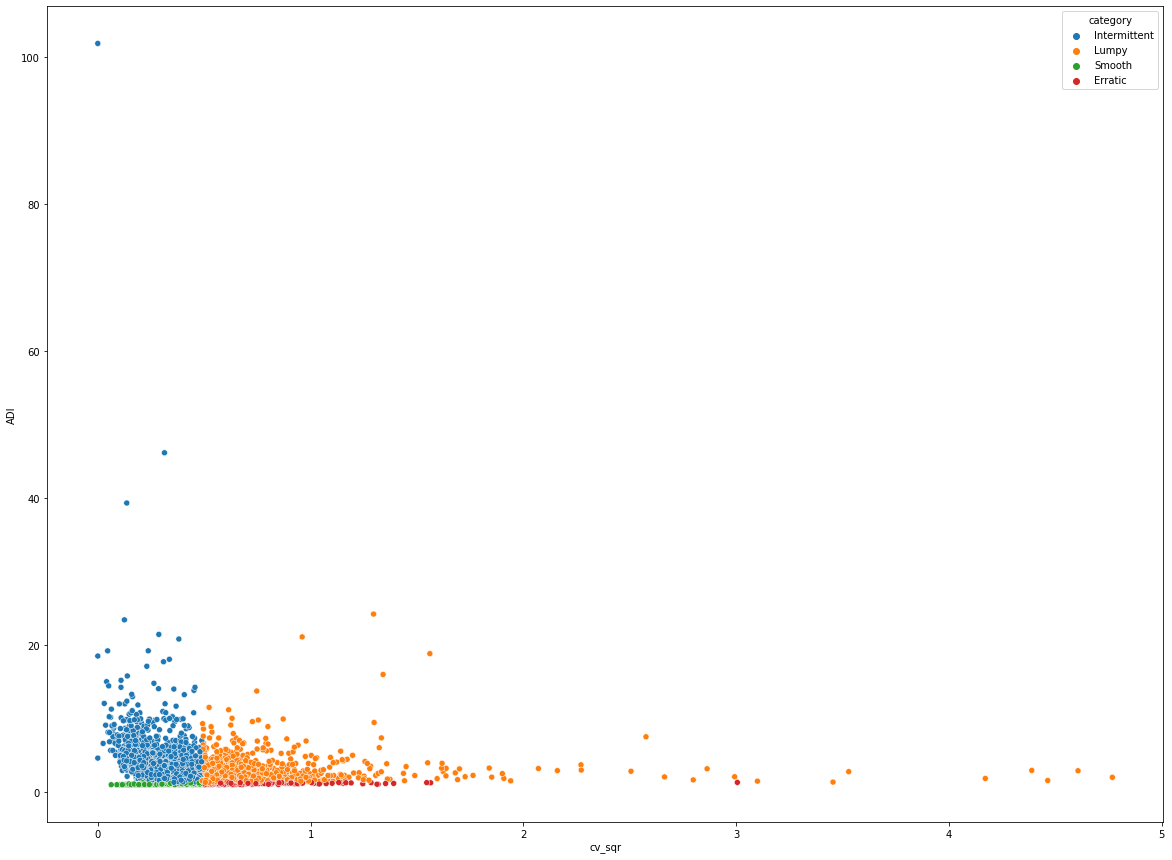

In [ ]:
plt.figure(figsize=(20,15))
sns.scatterplot(x='cv_sqr',y='ADI',hue='category',data=adi_cv)

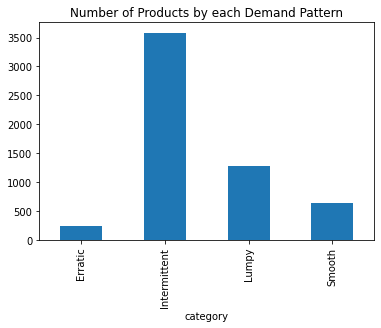

In [ ]:
adi_cv.groupby('category')['id'].count().plot(kind='bar')
plt.title('Number of Products by each Demand Pattern')
plt.show()

In [ ]:
list_intermittent = adi_cv[adi_cv['category'] == 'Intermittent']['id'].unique().tolist()
list_lumpy = adi_cv[adi_cv['category'] == 'Lumpy']['id'].unique().tolist()
list_smooth = adi_cv[adi_cv['category'] == 'Smooth']['id'].unique().tolist()
list_erratic = adi_cv[adi_cv['category'] == 'Erratic']['id'].unique().tolist()

In [ ]:
pd.Series(list_intermittent).to_csv('Intermittent_ID_2_Year_Data.csv')
pd.Series(list_lumpy).to_csv('Lumpy_ID_2_Year_Data.csv')
pd.Series(list_smooth).to_csv('Smooth_ID_2_Year_Data.csv')
pd.Series(list_erratic).to_csv('Erratic_ID_2_Year_Data.csv')